<a href="https://colab.research.google.com/github/lazarosgogos/ML-exercises/blob/main/ML_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Q1 - Load and visualise data

In [2]:
df = pd.read_csv('water_potability.csv')
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


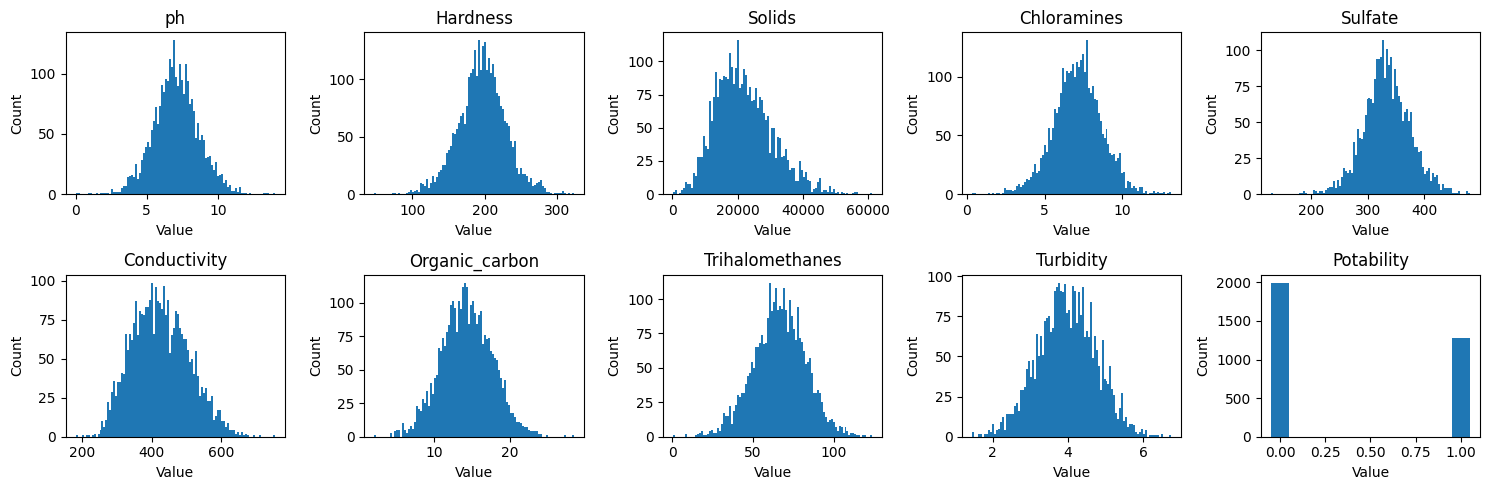

In [18]:
cols = df.columns
plt.figure(1, figsize=(15,5))
for i, col in enumerate(cols):
  plt.subplot(2,5,i+1)
  if col != cols[-1]:
    plt.hist(df[col], bins=100, )
  else:
    plt.bar([0,1], df[col].value_counts(), width=.1)
  plt.title(col)
  plt.xlabel('Value')
  plt.ylabel('Count')
plt.tight_layout()

Count missing values per feature and sample percentage based on water potability.

In [34]:
print('Missing values per feature')
for col in cols:
  s = df[col].isna().sum()
  print(f'  {col:18s}: {s:6}')
pot_df = df[cols[-1]].value_counts()
potable_sum = pot_df[0]
non_potable_sum = pot_df[1]
total = len(df[cols[-1]])
print(f'Potable samples     : {potable_sum/total*100:.2f}%\nNon potable samples : {non_potable_sum/total*100:.2f}%')

Missing values per feature
  ph                :    491
  Hardness          :      0
  Solids            :      0
  Chloramines       :      0
  Sulfate           :    781
  Conductivity      :      0
  Organic_carbon    :      0
  Trihalomethanes   :    162
  Turbidity         :      0
  Potability        :      0
Potable samples     : 60.99%
Non potable samples : 39.01%


# Q2 - Examine  potable sample percentage based on pH value

In [53]:
ph_values = [(0, 6.5), (6.5, 8.5), (8.5, 14)] # (min,max) per tuple
print('Potability percentages based on pH value:')
for ph in ph_values:
  low, high = ph # unpack
  ph_df = df[(df['ph'] >= low) & (df['ph'] < high)]
  potable_counts = ph_df['Potability'].value_counts()
  zeros, ones = potable_counts
  total = len(ph_df)
  print(f'  When the pH value is in [{low}, {high}): \n\
    Non-potable samples : {zeros/total*100:.2f}%\n\
    Potable samples     : {ones/total*100:.2f}%')

Potability percentages based on pH value:
  When the pH value is in [0, 6.5): 
    Non-potable samples : 63.22%
    Potable samples     : 36.78%
  When the pH value is in [6.5, 8.5): 
    Non-potable samples : 56.10%
    Potable samples     : 43.90%
  When the pH value is in [8.5, 14): 
    Non-potable samples : 66.87%
    Potable samples     : 33.13%


Based on the results above, truly most of the potable samples are to be found when the water's pH value is in the range [6.5, 8.5]. However, as other factors (feature values) come into play as well, not all samples in that pH range are potable

# Q3 - Chloramine and pH value cross-examination

Text(0.5, 1.0, 'Cross-examination')

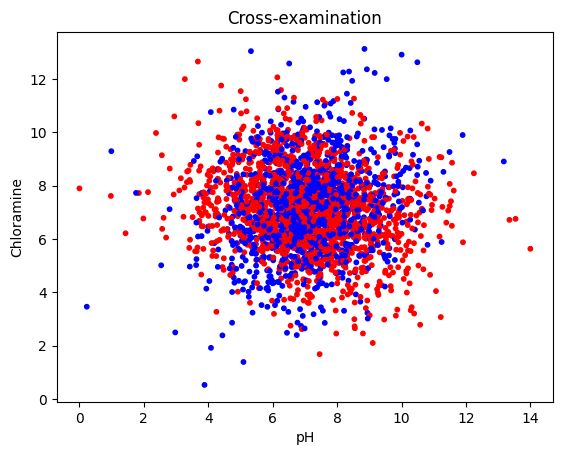

In [61]:
mask = ~df['ph'].isna() # we need to ignore these values
masked_df = df[mask]
ph_df = masked_df['ph']
chlor_df = masked_df['Chloramines']
color = np.where(masked_df['Potability'] == 1, 'blue', 'red')
plt.scatter(ph_df, chlor_df, s=10, c=color)
plt.xlabel('pH')
plt.ylabel('Chloramine')
plt.title('Cross-examination');

As shown in the scatter plot above, the samples cannot be linearly separated based on pH and Chloramine values. We would need another method to separate them.

# Q4 - Fill dataframe missing values

In [65]:
filled_df = df.copy()
for col in cols:
  filled_df[col] = df[col].fillna(df[col].mean())

# Q5 - Create dataset to train tree classifiers

In [78]:
x = np.array(filled_df.drop(columns=['Potability']))
y = np.array(filled_df['Potability'])

seed = 0
test_size = .3

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size,
                                                    random_state=seed)

# Q6 - Train a Decision Tree Classifier

In [82]:
dtree = DecisionTreeClassifier()
dtree.fit(x_train, y_train)

accu_train = dtree.score(x_train, y_train)
accu_test = dtree.score(x_test, y_test)

print(f'Train accuracy : {accu_train*100:6.2f}%\nTest accuracy  : {accu_test*100:6.2f}%')

Train accuracy : 100.00%
Test accuracy  :  56.77%
